# P8.1
Prepare a code which draw for given network plot of the relation
C(k). [1P]

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def plot_C_of_k(G):
    degrees = dict(G.degree())
    clustering = nx.clustering(G)

    ck = {}

    for node in G.nodes():
        k = degrees[node]
        c = clustering[node]

        if k not in ck:
            ck[k] = []
        ck[k].append(c)

    k_vals = sorted(ck.keys())
    Ck_vals = [np.mean(ck[k]) for k in k_vals]

    plt.figure()
    plt.scatter(k_vals, Ck_vals)
    plt.xlabel("k (node degree)")
    plt.ylabel("C(k) (average clustering coefficient)")
    plt.title("C(k) relation")
    plt.grid(True)
    plt.show()


# P8.2
Find examples of hierarchical and non-hierarchical networks in
available repositories, check by drawing graphs from the task
P8.1. [0.5P]


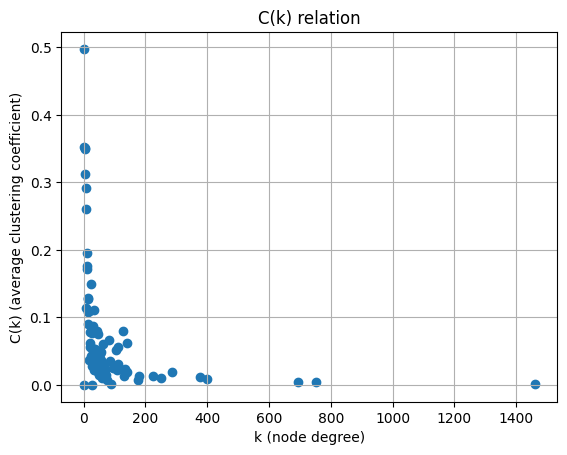

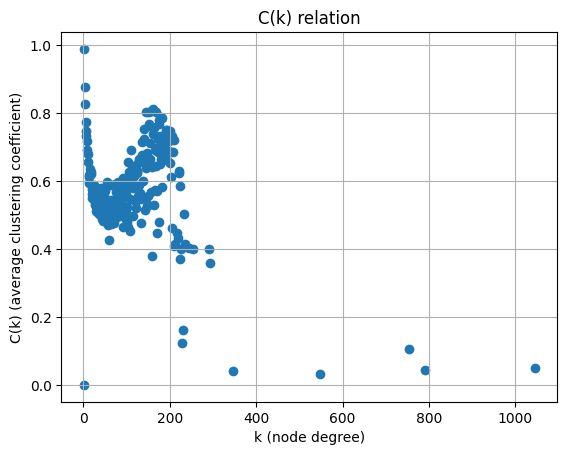

In [9]:
G = nx.read_edgelist("as20000102.txt", nodetype=int)
plot_C_of_k(G)

G = nx.read_edgelist("facebook_combined.txt",
                     delimiter=" ", nodetype=int, data=False)

plot_C_of_k(G)

https://snap.stanford.edu/data/as-733.html

https://snap.stanford.edu/data/ego-Facebook.html



# P8.3
Load (perhaps a sub-) set of stops from the data provided by
ZTM Warszawa on the website www.ztm.waw.pl/
pliki-do-pobrania/dane-rozkladowe/. Draw graphs
based on this set of vertices associated with the various types
of mass transport. [2.5P] (for publishing parser for other
students + 1.5P)


route_type
3    2159
2     230
0     202
Name: count, dtype: int64


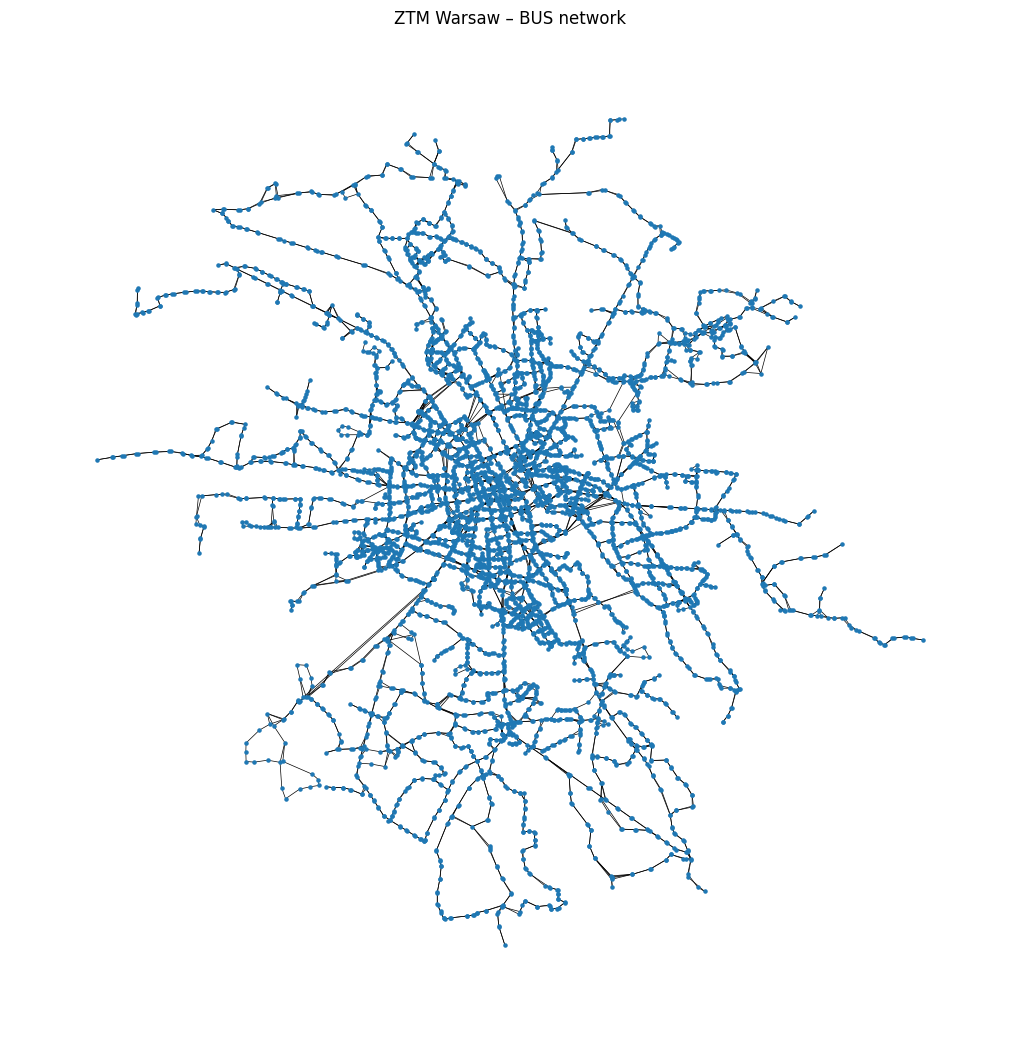

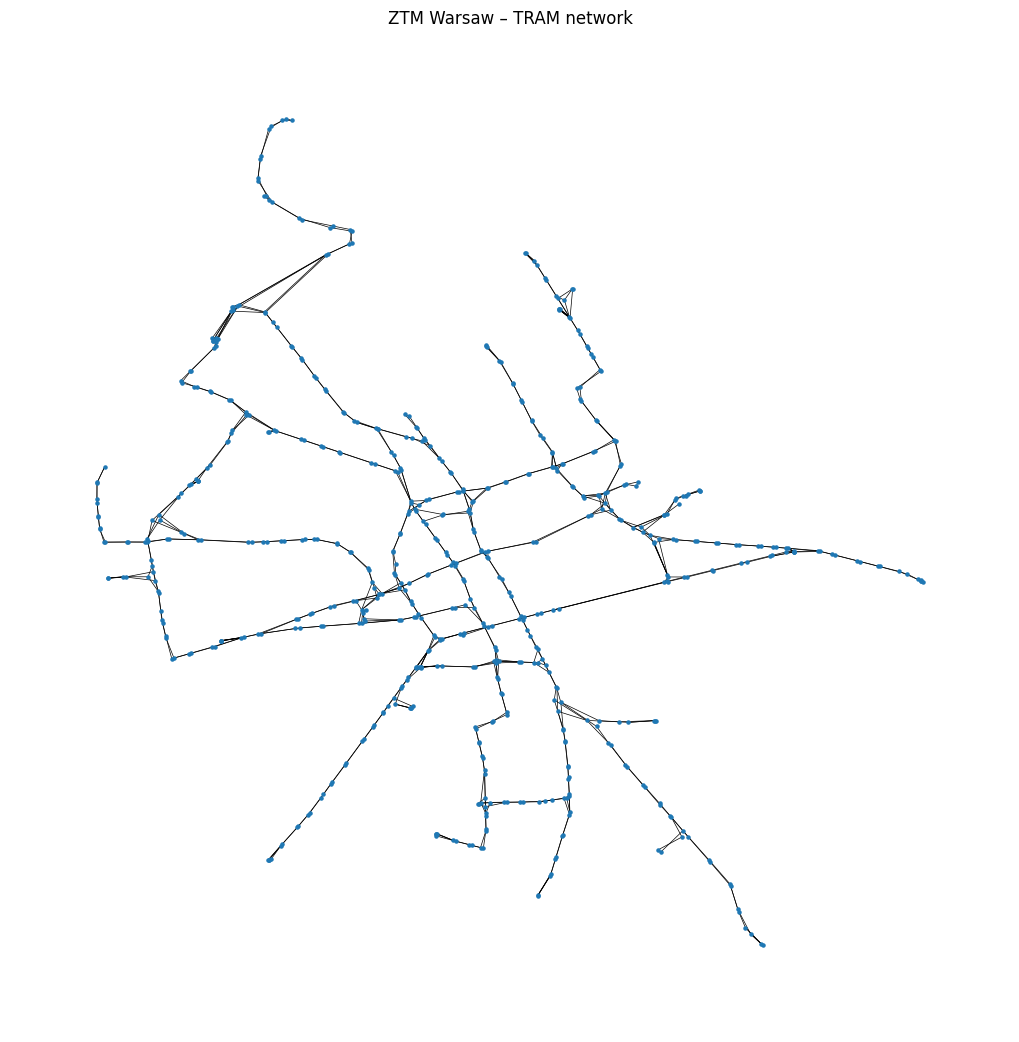

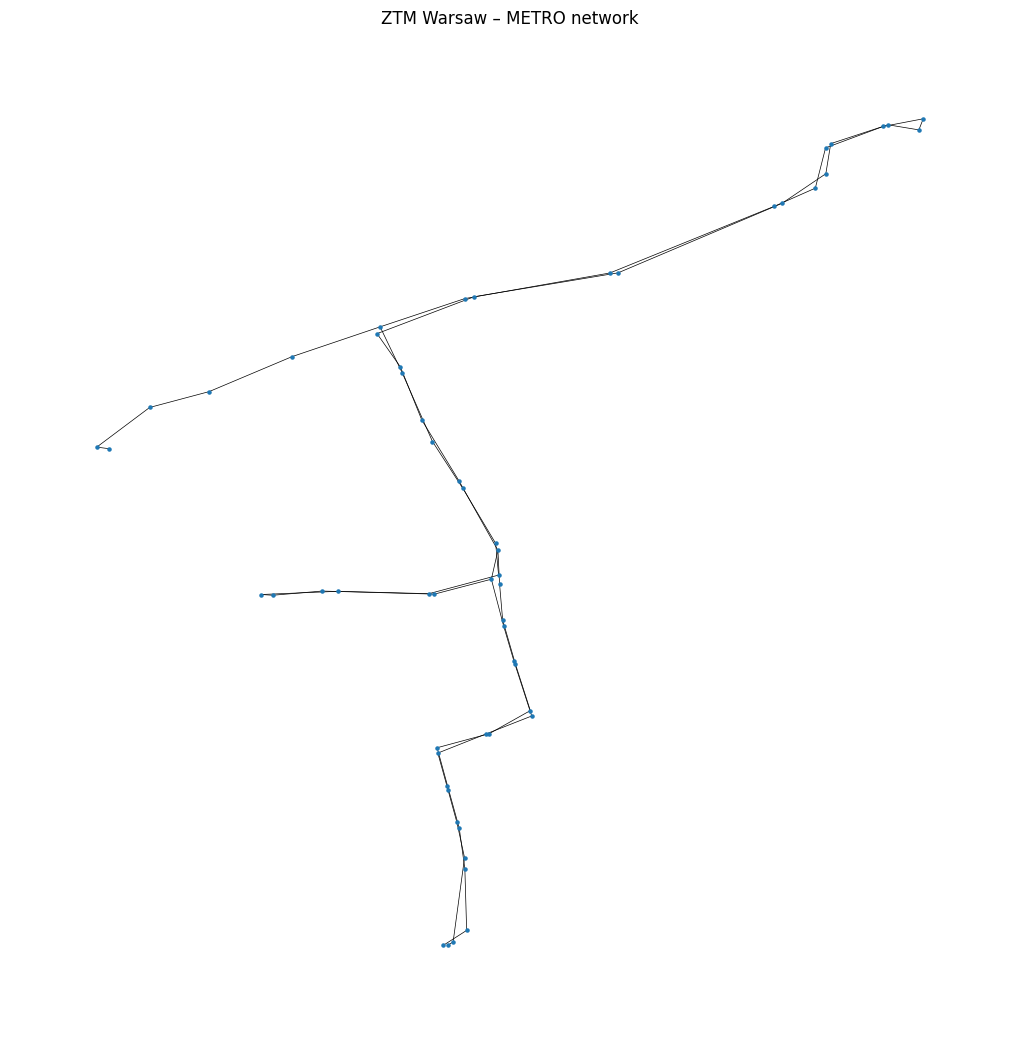

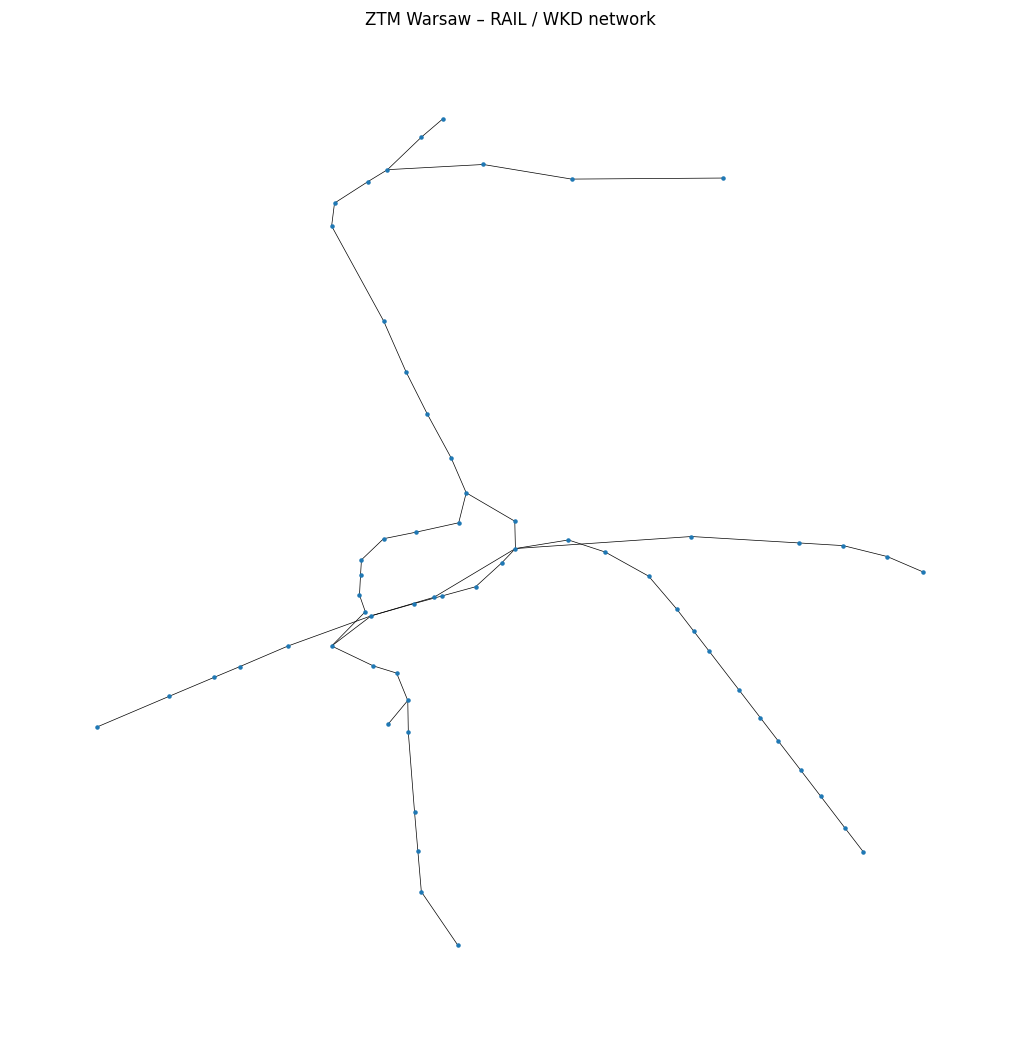

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

STOPS_FILE = "stops.txt"
ROUTES_FILE = "routes.txt"
TRIPS_FILE = "trips.txt"
STOP_TIMES_FILE = "stop_times.txt"


def load_gtfs():
    stops = pd.read_csv(STOPS_FILE)
    routes = pd.read_csv(ROUTES_FILE)
    print(routes["route_type"].value_counts())
    trips = pd.read_csv(TRIPS_FILE)
    stop_times = pd.read_csv(STOP_TIMES_FILE)
    return stops, routes, trips, stop_times


def build_transport_graphs(stops, routes, trips, stop_times):
    trip_route_map = dict(zip(trips["trip_id"], trips["route_id"]))

    graphs = {
        "tram": nx.Graph(),
        "metro": nx.Graph(),
        "rail": nx.Graph(),
        "bus": nx.Graph(),
    }

    stops_dict = {
        row["stop_id"]: (row["stop_name"], row["stop_lat"], row["stop_lon"])
        for _, row in stops.iterrows()
    }

    routes_dict = {
        row["route_id"]: (row["route_type"], str(row["route_short_name"]))
        for _, row in routes.iterrows()
    }

    stop_times = stop_times.sort_values(by=["trip_id", "stop_sequence"])

    for trip_id, group in stop_times.groupby("trip_id"):

        if trip_id not in trip_route_map:
            continue

        route_id = trip_route_map[trip_id]

        if route_id not in routes_dict:
            continue

        route_type, short_name = routes_dict[route_id]

        if short_name.startswith("M"):
            G = graphs["metro"]
        elif route_type == 0:
            G = graphs["tram"]
        elif route_type == 2:
            G = graphs["rail"]
        elif route_type == 3:
            G = graphs["bus"]
        else:
            continue

        stops_list = group["stop_id"].tolist()

        for stop_id in stops_list:
            if stop_id in stops_dict:
                name, lat, lon = stops_dict[stop_id]
                G.add_node(stop_id, name=name, pos=(lon, lat))

        for i in range(len(stops_list) - 1):
            G.add_edge(stops_list[i], stops_list[i + 1])

    return graphs



def draw_transport_graph(G, title):
    pos = nx.get_node_attributes(G, "pos")

    plt.figure(figsize=(10, 10))
    nx.draw(
        G,
        pos,
        node_size=5,
        width=0.5,
        with_labels=False
    )
    plt.title(title)
    plt.show()


if __name__ == "__main__":
    stops, routes, trips, stop_times = load_gtfs()
    graphs = build_transport_graphs(stops, routes, trips, stop_times)

    draw_transport_graph(graphs["bus"], "ZTM Warsaw – BUS network")
    draw_transport_graph(graphs["tram"], "ZTM Warsaw – TRAM network")
    draw_transport_graph(graphs["metro"], "ZTM Warsaw – METRO network")
    draw_transport_graph(graphs["rail"], "ZTM Warsaw – RAIL / WKD network")


# P8.4
 Calculate the basic characteristics of each layer, and the whole
network. [1P]


In [4]:
def basic_stats(G, name="network"):
    N = G.number_of_nodes()
    E = G.number_of_edges()

    if N > 0:
        avg_k = sum(dict(G.degree()).values()) / N
        density = nx.density(G)
        clustering = nx.average_clustering(G)
        components = nx.number_connected_components(G)

        if components == 1 and N > 1:
            diameter = nx.diameter(G)
        else:
            diameter = None
    else:
        avg_k = density = clustering = components = diameter = None

    print(f"\n=== {name.upper()} ===")
    print(f"Nodes (N): {N}")
    print(f"Edges (E): {E}")
    print(f"Average degree <k>: {avg_k:.3f}")
    print(f"Density ρ: {density:.6f}")
    print(f"Average clustering C: {clustering:.6f}")
    print(f"Connected components: {components}")
    print(f"Diameter: {diameter}")


In [5]:
basic_stats(graphs["bus"], "BUS layer")
basic_stats(graphs["tram"], "TRAM layer")
basic_stats(graphs["rail"], "RAIL / WKD layer")
basic_stats(graphs["metro"], "METRO layer")

G_all = nx.compose_all([
    graphs["bus"],
    graphs["tram"],
    graphs["rail"],
    graphs["metro"]
])

basic_stats(G_all, "WHOLE TRANSPORT NETWORK")



=== BUS LAYER ===
Nodes (N): 6099
Edges (E): 8060
Average degree <k>: 2.643
Density ρ: 0.000433
Average clustering C: 0.023472
Connected components: 1
Diameter: 123

=== TRAM LAYER ===
Nodes (N): 622
Edges (E): 764
Average degree <k>: 2.457
Density ρ: 0.003956
Average clustering C: 0.001983
Connected components: 1
Diameter: 48

=== RAIL / WKD LAYER ===
Nodes (N): 62
Edges (E): 63
Average degree <k>: 2.032
Density ρ: 0.033316
Average clustering C: 0.000000
Connected components: 1
Diameter: 26

=== METRO LAYER ===
Nodes (N): 58
Edges (E): 58
Average degree <k>: 2.000
Density ρ: 0.035088
Average clustering C: 0.000000
Connected components: 1
Diameter: 29

=== WHOLE TRANSPORT NETWORK ===
Nodes (N): 6767
Edges (E): 8885
Average degree <k>: 2.626
Density ρ: 0.000388
Average clustering C: 0.021322
Connected components: 2
Diameter: None


# P8.5
 Translate GPS coordinates to configuration of the vertices and
draw graph in proper, geographic, configuration. [2P]


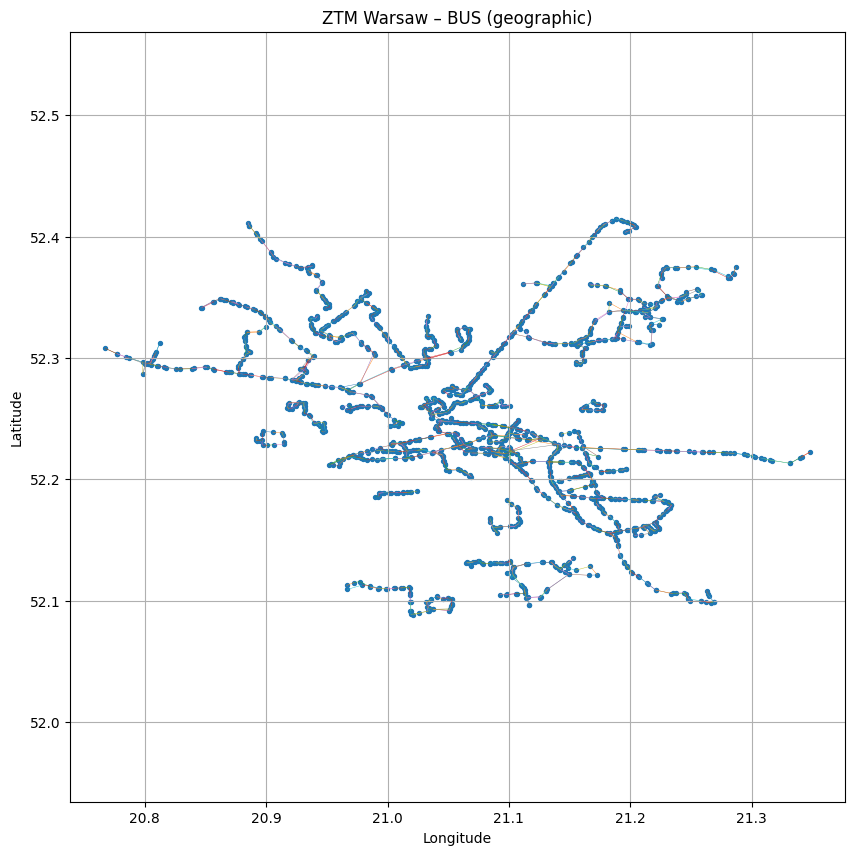

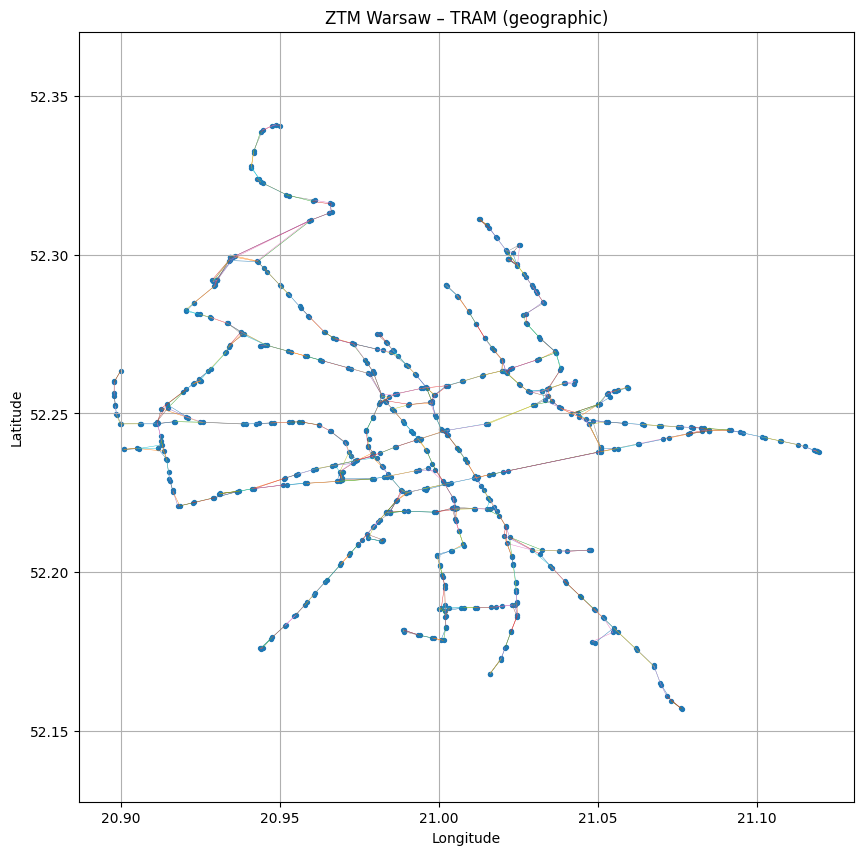

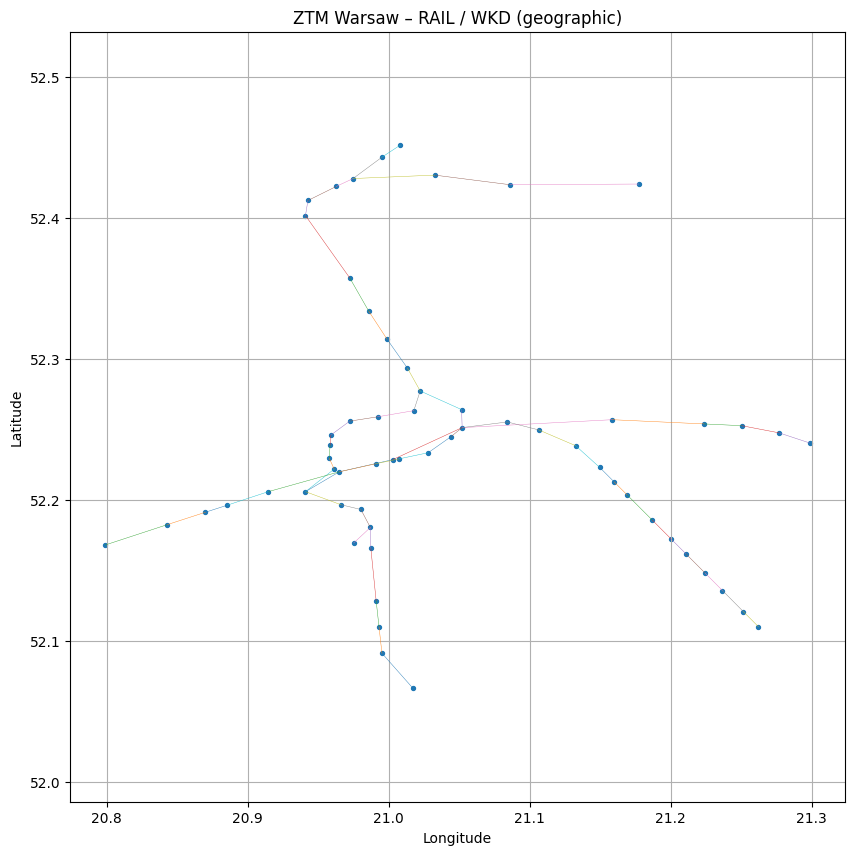

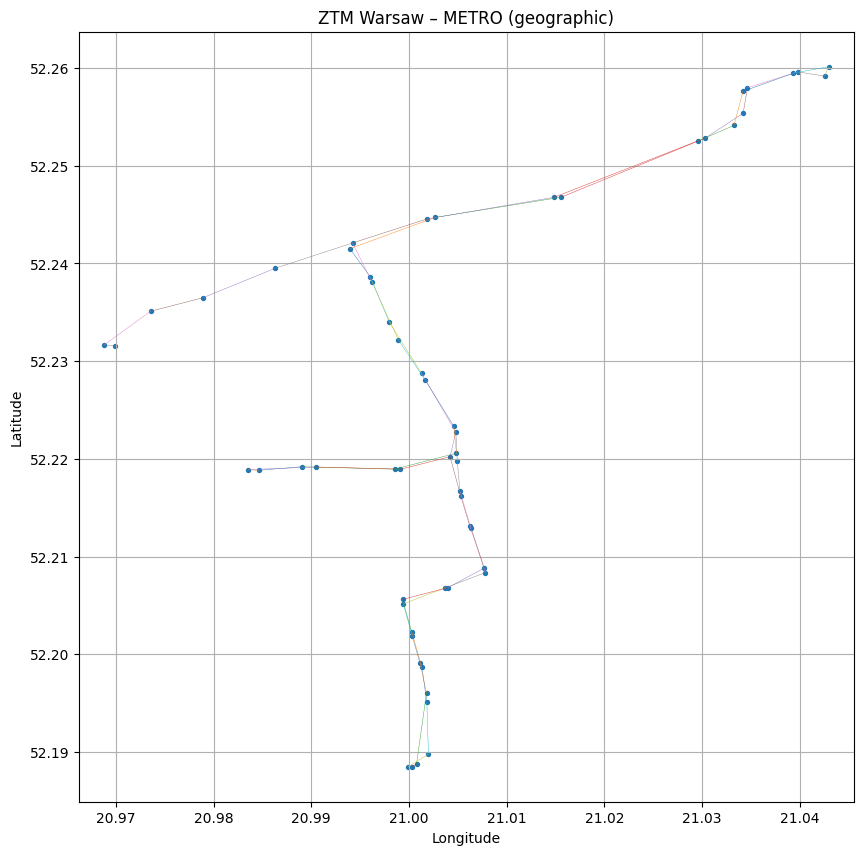

In [6]:
def draw_geographic_graph(G, title, max_nodes=None):
    pos = nx.get_node_attributes(G, "pos")

    if max_nodes is not None and len(G) > max_nodes:
        nodes = list(G.nodes())[:max_nodes]
        G = G.subgraph(nodes)
        pos = {k: pos[k] for k in G.nodes()}

    lons = [p[0] for p in pos.values()]
    lats = [p[1] for p in pos.values()]

    plt.figure(figsize=(10, 10))

    for u, v in G.edges():
        if u in pos and v in pos:
            x = [pos[u][0], pos[v][0]]
            y = [pos[u][1], pos[v][1]]
            plt.plot(x, y, linewidth=0.3)

    plt.scatter(lons, lats, s=8)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)

    plt.axis("equal")   #
    plt.grid(True)
    plt.show()


draw_geographic_graph(graphs["bus"], "ZTM Warsaw – BUS (geographic)", max_nodes=1500)
draw_geographic_graph(graphs["tram"], "ZTM Warsaw – TRAM (geographic)")
draw_geographic_graph(graphs["rail"], "ZTM Warsaw – RAIL / WKD (geographic)")
draw_geographic_graph(graphs["metro"], "ZTM Warsaw – METRO (geographic)")


# P8.6
 Taking into account the time table data, obtain the temporal
network from the graphs from the previous task. [1P]


In [9]:
def build_temporal_networks_fast(stops, routes, trips, stop_times):

    route_type_map = dict(zip(routes["route_id"], routes["route_type"]))
    route_name_map = dict(zip(routes["route_id"], routes["route_short_name"]))
    trip_route_map = dict(zip(trips["trip_id"], trips["route_id"]))

    df = stop_times.copy()

    df["next_stop"] = df.groupby("trip_id")["stop_id"].shift(-1)
    df["next_time"] = df.groupby("trip_id")["arrival_time"].shift(-1)

    df = df.dropna(subset=["next_stop"])

    df["route_id"] = df["trip_id"].map(trip_route_map)
    df["route_type"] = df["route_id"].map(route_type_map)
    df["route_name"] = df["route_id"].map(route_name_map).astype(str)

    df["layer"] = "bus"

    df.loc[df["route_type"] == 0, "layer"] = "tram"
    df.loc[df["route_type"] == 2, "layer"] = "rail"
    df.loc[df["route_name"].str.startswith("M"), "layer"] = "metro"

    temporal_graphs = {
        "bus": [],
        "tram": [],
        "rail": [],
        "metro": [],
    }

    for layer in temporal_graphs:
        sub = df[df["layer"] == layer]

        temporal_graphs[layer] = list(
            zip(
                sub["stop_id"].astype(int),
                sub["next_stop"].astype(int),
                sub["departure_time"],
                sub["next_time"]
            )
        )

    return temporal_graphs


temporal_networks = build_temporal_networks_fast(stops, routes, trips, stop_times)

print("Temporal BUS edges:", len(temporal_networks["bus"]))
print("Temporal TRAM edges:", len(temporal_networks["tram"]))
print("Temporal RAIL edges:", len(temporal_networks["rail"]))
print("Temporal METRO edges:", len(temporal_networks["metro"]))


Temporal BUS edges: 4651475
Temporal TRAM edges: 1327290
Temporal RAIL edges: 39763
Temporal METRO edges: 1018


# P8.7
 Make an animation of how traffic flows throughout the day. [2.5P]


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved as: bus_traffic.gif


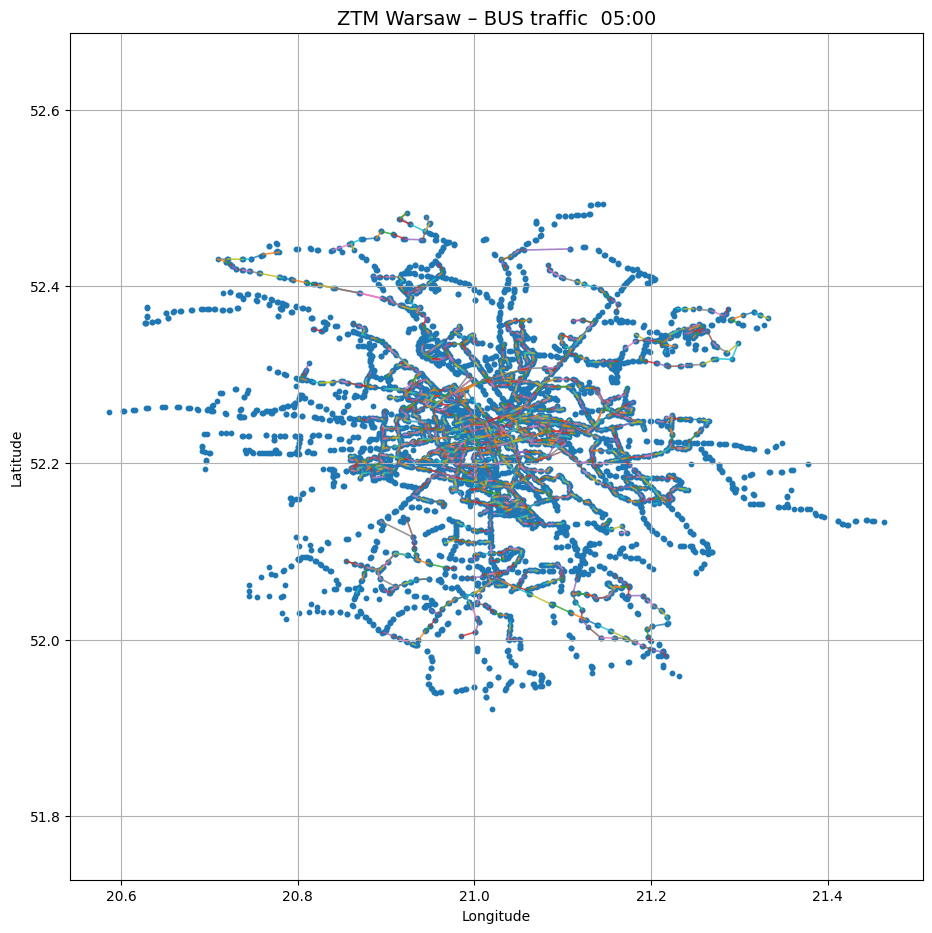

In [15]:
from matplotlib.animation import FuncAnimation

def time_to_minutes(t):
    h, m, s = map(int, t.split(":"))
    return 60*h + m


from matplotlib.animation import FuncAnimation

def time_to_minutes(t):
    h, m, s = map(int, t.split(":"))
    return 60*h + m


def make_traffic_animation(temporal_edges, pos, title="Traffic flow",
                            t_start="05:00:00", t_end="23:00:00",
                            step_minutes=10, max_edges=4000,
                            save_file="traffic.gif"):

    data = []
    for u, v, t_dep, t_arr in temporal_edges:
        data.append((u, v, time_to_minutes(t_dep)))

    t_min = time_to_minutes(t_start)
    t_max = time_to_minutes(t_end)

    frames = list(range(t_min, t_max, step_minutes))

    fig, ax = plt.subplots(figsize=(11, 11))

    def update(frame_time):
        ax.clear()

        current_edges = [
            (u, v) for u, v, t in data
            if frame_time <= t < frame_time + step_minutes
            and u in pos and v in pos
        ]

        current_edges = current_edges[:max_edges]

        for u, v in current_edges:
            x = [pos[u][0], pos[v][0]]
            y = [pos[u][1], pos[v][1]]
            ax.plot(x, y, linewidth=1.2, alpha=0.8)

        lons = [p[0] for p in pos.values()]
        lats = [p[1] for p in pos.values()]
        ax.scatter(lons, lats, s=10)

        hour = frame_time // 60
        minute = frame_time % 60
        ax.set_title(f"{title}  {hour:02d}:{minute:02d}", fontsize=14)

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.axis("equal")
        ax.grid(True)

    anim = FuncAnimation(fig, update, frames=frames, interval=500)
    anim.save(save_file)
    print(f"Animation saved as: {save_file}")



pos = nx.get_node_attributes(graphs["bus"], "pos")

make_traffic_animation(
    temporal_networks["bus"],
    pos,
    title="ZTM Warsaw – BUS traffic",
    t_start="05:00:00",
    t_end="23:00:00",
    step_minutes=20,
    max_edges=5000,
    save_file="bus_traffic.gif"
)


# P8.8
 Check how the selected network metrics depend on time. [1P]


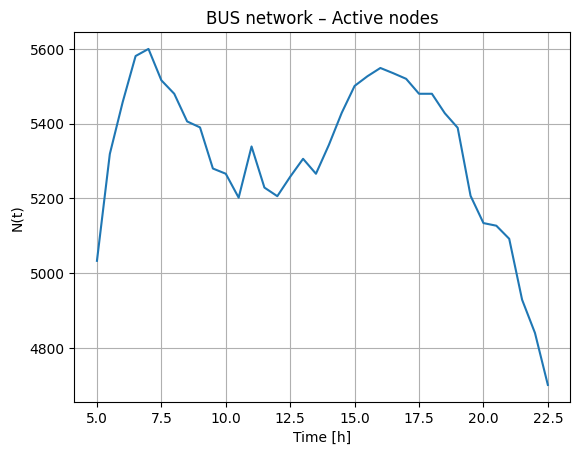

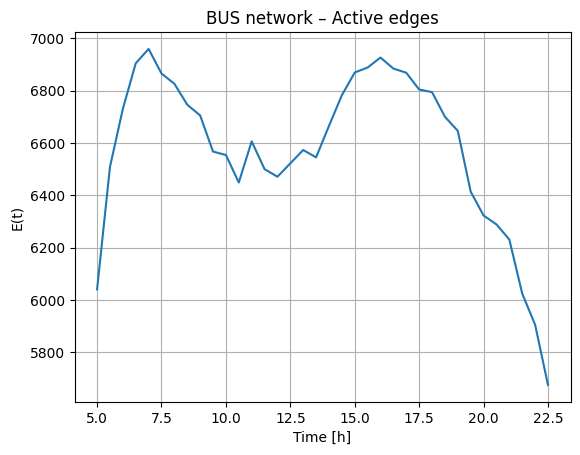

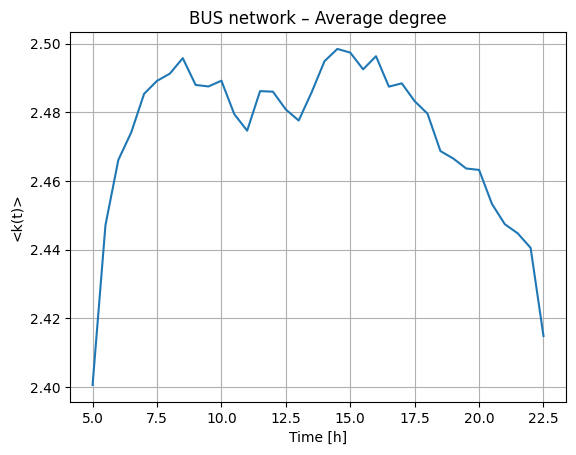

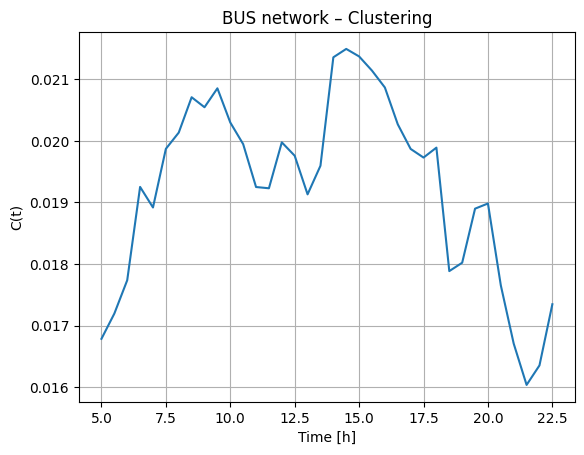

In [13]:
def time_to_minutes(t):
    h, m, s = map(int, t.split(":"))
    return 60*h + m


def temporal_snapshot_graph(temporal_edges, t_min, t_max):
    G = nx.Graph()
    for u, v, t_dep, t_arr in temporal_edges:
        t = time_to_minutes(t_dep)
        if t_min <= t < t_max:
            G.add_edge(u, v)
    return G


def temporal_metrics(temporal_edges, t_start="05:00:00", t_end="23:00:00", step_minutes=30):
    t0 = time_to_minutes(t_start)
    t1 = time_to_minutes(t_end)

    times = []
    N_vals = []
    E_vals = []
    k_vals = []
    C_vals = []

    for t in range(t0, t1, step_minutes):
        G = temporal_snapshot_graph(temporal_edges, t, t + step_minutes)

        N = G.number_of_nodes()
        E = G.number_of_edges()

        if N > 0:
            avg_k = sum(dict(G.degree()).values()) / N
            C = nx.average_clustering(G)
        else:
            avg_k = 0
            C = 0

        times.append(t)
        N_vals.append(N)
        E_vals.append(E)
        k_vals.append(avg_k)
        C_vals.append(C)

    return times, N_vals, E_vals, k_vals, C_vals


def plot_temporal_metrics(times, N, E, K, C, title="Temporal metrics"):

    times_h = [t / 60 for t in times]

    plt.figure()
    plt.plot(times_h, N)
    plt.xlabel("Time [h]")
    plt.ylabel("N(t)")
    plt.title(title + " – Active nodes")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(times_h, E)
    plt.xlabel("Time [h]")
    plt.ylabel("E(t)")
    plt.title(title + " – Active edges")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(times_h, K)
    plt.xlabel("Time [h]")
    plt.ylabel("<k(t)>")
    plt.title(title + " – Average degree")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(times_h, C)
    plt.xlabel("Time [h]")
    plt.ylabel("C(t)")
    plt.title(title + " – Clustering")
    plt.grid(True)
    plt.show()


times, N, E, K, C = temporal_metrics(
    temporal_networks["bus"],
    t_start="05:00:00",
    t_end="23:00:00",
    step_minutes=30
)

plot_temporal_metrics(times, N, E, K, C, title="BUS network")
